In [12]:
import os
import numpy as np
import pandas as pd        
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import community as community_louvain

import torch
import torch.nn.functional as F
import torch_geometric
from torch import Tensor
from torch_geometric.nn import GCNConv, GATConv, GINConv
from torch_geometric.data import Data 
from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score,
    confusion_matrix, 
    classification_report,
    ConfusionMatrixDisplay
)
from sklearn.preprocessing import LabelEncoder
from scipy.stats import ttest_ind

print("Torch version:", torch.__version__)
print("Torch Geometric version:", torch_geometric.__version__)

Torch version: 2.5.1+cu121
Torch Geometric version: 2.6.1


In [13]:
RANDOM_STATE = 42
NUM_EPOCHS = 100
def set_seed_for_torch(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)      # For single-GPU.
        torch.cuda.manual_seed_all(seed)  # For multi-GPU.
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    
def set_seed_for_numpy(seed):
    np.random.seed(seed) 
    
def set_seed_for_random(seed):
    random.seed(seed)  
set_seed_for_torch(RANDOM_STATE)
set_seed_for_numpy(RANDOM_STATE)
set_seed_for_random(RANDOM_STATE)

In [14]:
elliptic_txs_features = pd.read_csv('elliptic_txs_features.csv', header=None)
elliptic_txs_classes = pd.read_csv('elliptic_txs_classes.csv')
elliptic_txs_edgelist = pd.read_csv('elliptic_txs_edgelist.csv')

elliptic_txs_features.columns = ['txId'] + [f'V{i}' for i in range(1, 167)]

print(f"""Shapes
{4*' '}Features : {elliptic_txs_features.shape[0]:8,} (rows)  {elliptic_txs_features.shape[1]:4,} (cols)
{4*' '}Classes  : {elliptic_txs_classes.shape[0]:8,} (rows)  {elliptic_txs_classes.shape[1]:4,} (cols)
{4*' '}Edgelist : {elliptic_txs_edgelist.shape[0]:8,} (rows)  {elliptic_txs_edgelist.shape[1]:4,} (cols)
""")

Shapes
    Features :  203,769 (rows)   167 (cols)
    Classes  :  203,769 (rows)     2 (cols)
    Edgelist :  234,355 (rows)     2 (cols)



图神经网络
图神经网络（GNN）是一种专为图数据设计的深度学习技术，适用于节点分类、图分类或边的预测等任务。在我们的例子中，目前我们将执行____节点预测____。

In [15]:
num_edges = elliptic_txs_edgelist.shape[0]
num_nodes = elliptic_txs_features.shape[0]

print(f'Number of edges in the graph: {num_edges:8,}')
print(f'Number of nodes in the graph: {num_nodes:8,}')

Number of edges in the graph:  234,355
Number of nodes in the graph:  203,769


In [16]:
tx_id_mapping = {tx_id: idx for idx, tx_id in enumerate(elliptic_txs_features['txId'])}

edges_with_features = elliptic_txs_edgelist[elliptic_txs_edgelist['txId1'].isin(list(tx_id_mapping.keys()))\
                                          & elliptic_txs_edgelist['txId2'].isin(list(tx_id_mapping.keys()))]

edges_with_features['Id1'] = edges_with_features['txId1'].map(tx_id_mapping)
edges_with_features['Id2'] = edges_with_features['txId2'].map(tx_id_mapping)

edges_with_features

,txId1,txId2,Id1,Id2
0,230425980,5530458,0,1
1,232022460,232438397,2,3
2,230460314,230459870,4,5
3,230333930,230595899,6,7
4,232013274,232029206,8,9
...,...,...,...,...
234350,158365409,157930723,203602,201430
234351,188708874,188708879,203603,203099
234352,157659064,157659046,201921,202042
234353,87414554,106877725,201480,201368


In [17]:
edge_index = torch.tensor(edges_with_features[['Id1', 'Id2']].values.T, dtype=torch.long)
edge_index

tensor([[     0,      2,      4,  ..., 201921, 201480, 201954],
        [     1,      3,      5,  ..., 202042, 201368, 201756]])

In [18]:
# 将节点特征从DataFrame转换为PyTorch张量
# elliptic_txs_features.drop(columns=['txId']) 
#        - 删除'txId'列，因为这是交易标识符，不是特征值
#        - 保留所有特征列（V1, V2, ..., V166，共166个特征）

node_features = torch.tensor(elliptic_txs_features.drop(columns=['txId']).values, 
                             dtype=torch.float)

print(node_features.shape)
node_features[:2]

torch.Size([203769, 166])


tensor([[ 1.0000e+00, -1.7147e-01, -1.8467e-01, -1.2014e+00, -1.2197e-01,
         -4.3875e-02, -1.1300e-01, -6.1584e-02, -1.6210e-01, -1.6793e-01,
         -4.9707e-02, -1.6440e-01, -2.8741e-02, -3.5391e-02, -4.2955e-02,
         -1.3282e-02, -5.7195e-02, -1.6961e-01, -1.7115e-01, -1.7447e-01,
         -1.3737e+00, -1.3715e+00, -1.3973e-01, -1.4891e-01, -8.0147e-02,
         -1.5566e-01, -1.0763e-02, -1.2107e-02, -1.3973e-01, -1.4891e-01,
         -8.0147e-02, -1.5566e-01, -1.0669e-02, -1.2005e-02, -2.4669e-02,
         -3.1272e-02, -2.3045e-02, -2.6215e-02,  1.4278e-03,  1.4826e-03,
         -2.2722e-01, -2.3937e-01, -7.5256e-02, -2.3495e-01,  3.7468e-02,
          4.3444e-02, -2.2720e-01, -2.4324e-01, -9.7895e-02, -2.3590e-01,
          3.6577e-02,  4.2345e-02, -4.1401e-01, -4.8834e-01, -2.3255e-01,
         -4.6755e-01,  4.8767e-02,  5.2956e-02, -3.9149e-02, -1.7290e-01,
         -1.6313e-01, -1.6093e-01, -1.3163e+00, -1.3154e+00, -3.9144e-02,
         -1.7288e-01, -1.6311e-01, -1.

In [19]:
elliptic_txs_classes['class'].value_counts()

class
unknown    157205
2           42019
1            4545
Name: count, dtype: int64

In [20]:
# 标签编码
le = LabelEncoder()
class_labels = le.fit_transform(elliptic_txs_classes['class'])
node_labels = torch.tensor(class_labels, dtype=torch.long)
original_labels = le.inverse_transform(class_labels)

print(original_labels)
print(class_labels)
print(node_labels)

['unknown' 'unknown' 'unknown' ... '1' 'unknown' 'unknown']
[2 2 2 ... 0 2 2]
tensor([2, 2, 2,  ..., 0, 2, 2])


In [21]:
print(le.inverse_transform([0])) # illicit
print(le.inverse_transform([1])) # licit 
print(le.inverse_transform([2])) # unknown

['1']
['2']
['unknown']


In [25]:
data = Data(x=node_features, 
            edge_index=edge_index, 
            y=node_labels)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Move data to GPU.
data = data.to(device)
device

device(type='cuda')

但是，在这个对象中，我们仍然有很多_未知_ 🤷 ，我们不想在这些节点上训练我们的 GNN。我们只想在已知节点上进行训练，即那些_licit_ ✅ 或 illicit ❌ 的节点。

把位未知的标签的数据进行掩码

In [29]:
known_mask = (data.y == 0) | (data.y == 1)  # 只要已知的标签  licit or illicit
unknown_mask = data.y == 2                    # 未知标签掩码
known_mask

tensor([False, False, False,  ...,  True, False, False], device='cuda:0')

In [34]:
num_known_nodes = known_mask.sum().item()
permutations = torch.randperm(num_known_nodes)
train_size = int(0.8 * num_known_nodes)      #8成训练
val_size = int(0.1 * num_known_nodes)        #1成验证
test_size = num_known_nodes - train_size - val_size  #1验测试
total = np.sum([train_size, val_size, test_size])

print(f"""Number of observations per split
    Training   : {train_size:10,} ({100*train_size/total:0.2f} %)
    Validation : {val_size:10,} ({100*val_size/total:0.2f} %)
    Testing    : {test_size:10,} ({100*test_size/total:0.2f} %)
""")

Number of observations per split
    Training   :     37,251 (80.00 %)
    Validation :      4,656 (10.00 %)
    Testing    :      4,657 (10.00 %)



In [35]:
# 为训练集、验证集、测试集创建掩码（mask） 标记哪些节点用于训练、验证、测试
# 注意：只对已知标签的节点（licit=0 或 illicit=1）进行划分，未知标签（unknown=2）的节点不参与

data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)

train_indices = known_mask.nonzero(as_tuple=True)[0][permutations[:train_size]]
val_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size:train_size + val_size]]
test_indices = known_mask.nonzero(as_tuple=True)[0][permutations[train_size + val_size:]]

data.train_mask[train_indices] = True
data.val_mask[val_indices] = True
data.test_mask[test_indices] = True

# 查看训练集掩码（显示前几个值，True表示该节点用于训练）
data.train_mask

tensor([False, False, False,  ...,  True, False, False])

In [36]:
# 数据集统计
# 用于训练的数据情况
train_licit, train_illicit = (data.y[data.train_mask] == 1).sum().item(), (data.y[data.train_mask] == 0).sum().item()
val_licit, val_illicit = (data.y[data.val_mask] == 1).sum().item(), (data.y[data.val_mask] == 0).sum().item()
test_licit, test_illicit = (data.y[data.test_mask] == 1).sum().item(), (data.y[data.test_mask] == 0).sum().item()

# C计算总量
train_total = train_licit + train_illicit
val_total = val_licit + val_illicit
test_total = test_licit + test_illicit

# 百分比
train_licit_pct = (train_licit / train_total) * 100
train_illicit_pct = (train_illicit / train_total) * 100
val_licit_pct = (val_licit / val_total) * 100
val_illicit_pct = (val_illicit / val_total) * 100
test_licit_pct = (test_licit / test_total) * 100
test_illicit_pct = (test_illicit / test_total) * 100

pd.DataFrame({
    'Set': ['Training', 'Validation', 'Testing'],
    'Total Count': [train_total, val_total, test_total],
    'Licit': [train_licit, val_licit, test_licit],
    'Licit (%)': [train_licit_pct, val_licit_pct, test_licit_pct],
    'Illicit': [train_illicit, val_illicit, test_illicit],
    'Illicit (%)': [train_illicit_pct, val_illicit_pct, test_illicit_pct]
})


,Set,Total Count,Licit,Licit (%),Illicit,Illicit (%)
0,Training,37251,33647,90.325092,3604,9.674908
1,Validation,4656,4173,89.626289,483,10.373711
2,Testing,4657,4199,90.165342,458,9.834658


In [38]:
mapped_classes = np.array(['illicit', 'licit'])
mapped_classes

array(['illicit', 'licit'], dtype='<U7')

In [53]:
# ==================== GCN模型定义 ====================
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, dropout=0.5):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)
        self.dropout = dropout
        
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # 第一层GCN + ReLU + Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 第二层GCN
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:

# ==================== 训练函数（带早停） ====================
def train_with_early_stopping(model, data, optimizer, criterion, 
                               max_epochs=200, patience=20, min_delta=0.001):
    """
    训练函数，带早停机制
    Args:
        model: GCN模型
        data: 图数据
        optimizer: 优化器
        criterion: 损失函数
        max_epochs: 最大训练轮次
        patience: 早停耐心值（验证集loss不下降的轮次）
        min_delta: 最小改善阈值
    Returns:
        train_losses: 训练损失列表
        val_losses: 验证损失列表
        best_epoch: 最佳epoch
    """
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0
    best_epoch = 0
    
    for epoch in range(1, max_epochs + 1):
        # 训练阶段
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            out = model(data)
            val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
            val_losses.append(val_loss.item())
        
        # 早停检查
        if val_loss.item() < best_val_loss - min_delta:
            best_val_loss = val_loss.item()
            patience_counter = 0
            best_epoch = epoch
            # 保存最佳模型
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
        
        # 打印进度
        if epoch % 10 == 0:
            print(f'Epoch {epoch:03d}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Best Epoch: {best_epoch}')
        
        # 早停触发
        if patience_counter >= patience:
            print(f'Early stopping at epoch {epoch}, best epoch: {best_epoch}')
            # 恢复最佳模型
            model.load_state_dict(best_model_state)
            break
    
    return train_losses, val_losses, best_epoch

In [ ]:
# ==================== 评估函数 ====================
def evaluate_model(model, data, mask, class_names=['Illicit', 'Licit']):
    """
    评估模型性能
    Returns:
        metrics: 包含准确率、精准度、召回率、F1的字典
        cm: 混淆矩阵
    """
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)
        
        # 转换为numpy
        y_true = data.y[mask].cpu().numpy()
        y_pred = pred[mask].cpu().numpy()
        
        # 计算指标
        accuracy = (pred[mask] == data.y[mask]).sum().item() / mask.sum().item()
        precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
        recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
        f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)
        
        # 混淆矩阵
        cm = confusion_matrix(y_true, y_pred)
        
        metrics = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }
        
    return metrics, cm, y_true, y_pred


In [65]:

# ==================== 网格搜索：学习率 + 模型结构 ====================
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 网格搜索的超参数范围
learning_rates = [0.001, 0.005, 0.01]  # 学习率
hidden_dims = [32, 64, 128]  # 隐藏层维度
dropouts = [0.3, 0.5, 0.7]  # Dropout率

# 模型参数
num_features = data.x.shape[1]  # 166
num_classes = 2  # illicit(0) 和 licit(1)

# 存储所有超参数组合的结果
results = {}
total_combinations = len(learning_rates) * len(hidden_dims) * len(dropouts)
current_combination = 0

print("开始网格搜索（学习率 + 模型结构）...")
print(f"总组合数: {total_combinations}")
print("=" * 60)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            current_combination += 1
            config_key = f"lr={lr}_hd={hidden_dim}_do={dropout}"
            
            print(f"\n[{current_combination}/{total_combinations}] 配置: {config_key}")
            print("-" * 60)
            
            # 创建模型
            model = GCN(num_features, hidden_dim, num_classes, dropout=dropout).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            criterion = nn.NLLLoss()
            
            # 训练（带早停）
            train_losses, val_losses, best_epoch = train_with_early_stopping(
                model, data, optimizer, criterion, 
                max_epochs=300, patience=20, min_delta=0.001
            )
            
            # 在验证集上评估
            val_metrics, _, _, _ = evaluate_model(model, data, data.val_mask)
            
            # 保存结果
            results[config_key] = {
                'lr': lr,
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_epoch': best_epoch,
                'val_metrics': val_metrics,
                'model': model
            }
            
            print(f"验证集 - 准确率: {val_metrics['accuracy']:.4f}, "
                  f"精准度: {val_metrics['precision']:.4f}, "
                  f"召回率: {val_metrics['recall']:.4f}, "
                  f"F1: {val_metrics['f1_score']:.4f}")

# 选择最佳配置（基于验证集F1分数）
best_config = max(results.keys(), key=lambda k: results[k]['val_metrics']['f1_score'])
best_result = results[best_config]

print("\n" + "=" * 60)
print("最佳配置:")
print(f"  学习率: {best_result['lr']}")
print(f"  隐藏层维度: {best_result['hidden_dim']}")
print(f"  Dropout: {best_result['dropout']}")
print(f"  验证集F1分数: {best_result['val_metrics']['f1_score']:.4f}")
print("=" * 60)

# 保存最佳配置的键，供后续使用
best_lr = best_result['lr']
best_hidden_dim = best_result['hidden_dim']
best_dropout = best_result['dropout']

Using device: cuda
开始网格搜索（学习率 + 模型结构）...
总组合数: 27

[1/27] 配置: lr=0.001_hd=32_do=0.3
------------------------------------------------------------
Epoch 010, Train Loss: 0.5156, Val Loss: 0.4174, Best Epoch: 8
Epoch 020, Train Loss: 0.4504, Val Loss: 0.3674, Best Epoch: 20
Epoch 030, Train Loss: 0.4050, Val Loss: 0.2936, Best Epoch: 30
Epoch 040, Train Loss: 0.3712, Val Loss: 0.2743, Best Epoch: 39
Epoch 050, Train Loss: 0.3498, Val Loss: 0.2691, Best Epoch: 50
Epoch 060, Train Loss: 0.3268, Val Loss: 0.2529, Best Epoch: 60
Epoch 070, Train Loss: 0.3122, Val Loss: 0.2415, Best Epoch: 70
Epoch 080, Train Loss: 0.2911, Val Loss: 0.2344, Best Epoch: 80
Epoch 090, Train Loss: 0.2817, Val Loss: 0.2266, Best Epoch: 90
Epoch 100, Train Loss: 0.2676, Val Loss: 0.2192, Best Epoch: 100
Epoch 110, Train Loss: 0.2583, Val Loss: 0.2132, Best Epoch: 110
Epoch 120, Train Loss: 0.2442, Val Loss: 0.2084, Best Epoch: 118
Epoch 130, Train Loss: 0.2327, Val Loss: 0.2044, Best Epoch: 130
Epoch 140, Train Los

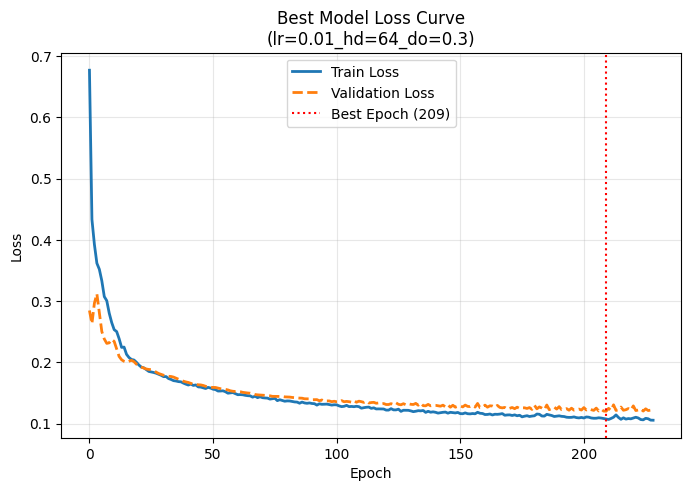

In [69]:
# ==================== 绘制Loss曲线 ====================
plt.figure(figsize=(8,5))
best_train_losses = best_result['train_losses']
best_val_losses = best_result['val_losses']
plt.plot(best_train_losses, label='Train Loss', linewidth=2)
plt.plot(best_val_losses, label='Validation Loss', linewidth=2, linestyle='--')
plt.axvline(x=best_result['best_epoch'], color='r', linestyle=':', 
            label=f'Best Epoch ({best_result["best_epoch"]})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best Model Loss Curve\n({best_config})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()


In [70]:
# ==================== 使用最佳模型在测试集上评估 ====================
# 获取最佳模型
best_model = best_result['model']

# 在测试集上评估
test_metrics, test_cm, y_true_test, y_pred_test = evaluate_model(
    best_model, data, data.test_mask, class_names=['Illicit', 'Licit']
)

# 打印测试集评估结果
print("=" * 60)
print("测试集评估结果:")
print("=" * 60)
print(f"模型配置: {best_config}")
print(f"准确率 (Accuracy):  {test_metrics['accuracy']:.4f}")
print(f"精准度 (Precision): {test_metrics['precision']:.4f}")
print(f"召回率 (Recall):    {test_metrics['recall']:.4f}")
print(f"F1分数 (F1-Score):  {test_metrics['f1_score']:.4f}")
print("=" * 60)

# 打印分类报告
print("\n分类报告:")
print(classification_report(y_true_test, y_pred_test, 
                            target_names=['Illicit', 'Licit'], 
                            digits=4))


测试集评估结果:
模型配置: lr=0.01_hd=64_do=0.3
准确率 (Accuracy):  0.9598
精准度 (Precision): 0.9581
召回率 (Recall):    0.9598
F1分数 (F1-Score):  0.9572

分类报告:
              precision    recall  f1-score   support

     Illicit     0.8950    0.6703    0.7665       458
       Licit     0.9650    0.9914    0.9780      4199

    accuracy                         0.9598      4657
   macro avg     0.9300    0.8309    0.8723      4657
weighted avg     0.9581    0.9598    0.9572      4657



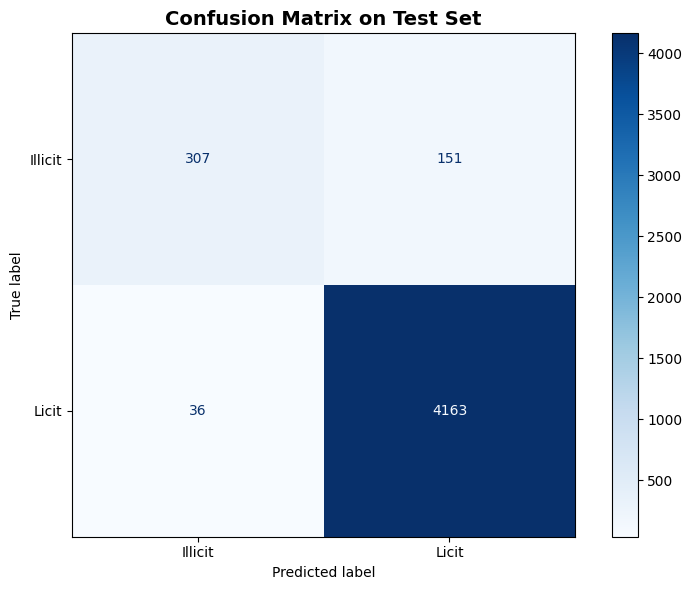

In [73]:

# ==================== 绘制测试集混淆矩阵 ====================
# 只显示测试集的混淆矩阵（使用sklearn的ConfusionMatrixDisplay）
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=test_cm, 
                              display_labels=['Illicit', 'Licit'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('Confusion Matrix on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

模型整体表现良好，准确率达95.98%，对合法交易（Licit）识别准确（召回率99.14%），但对非法交易（Illicit）存在约33%的漏检（召回率67.03%），可能将部分非法交易误判为合法，需要进一步优化以降低漏检风险。

# GAT (Graph Attention Network) 模型


In [74]:
# ==================== GAT模型定义 ====================
import torch.nn as nn
from torch_geometric.nn import GATConv

class GAT(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, heads=8, dropout=0.5):
        super(GAT, self).__init__()
        # 第一层GAT：多头注意力机制
        self.conv1 = GATConv(num_features, hidden_dim, heads=heads, dropout=dropout, concat=True)
        # 第二层GAT：输出层，使用单头注意力
        self.conv2 = GATConv(hidden_dim * heads, num_classes, heads=1, dropout=dropout, concat=False)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # 第一层GAT + ELU + Dropout
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 第二层GAT
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [79]:
# ==================== GAT网格搜索：学习率 + 模型结构 ====================
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 网格搜索的超参数范围
learning_rates = [0.001, 0.005]  # 学习率
hidden_dims = [16, 32]  # 隐藏层维度
dropouts = [0.3]  # Dropout率
heads_list = [4]  # 注意力头数

# 模型参数
num_features = data.x.shape[1]  # 166
num_classes = 2  # illicit(0) 和 licit(1)

# 存储所有超参数组合的结果
gat_results = {}
total_combinations = len(learning_rates) * len(hidden_dims) * len(dropouts) * len(heads_list)
current_combination = 0

print("开始GAT网格搜索（学习率 + 模型结构）...")
print(f"总组合数: {total_combinations}")
print("=" * 60)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            for heads in heads_list:
                current_combination += 1
                config_key = f"lr={lr}_hd={hidden_dim}_do={dropout}_heads={heads}"

                print(f"\n[{current_combination}/{total_combinations}] 配置: {config_key}")
                print("-" * 60)

                # 创建模型
                model = GAT(num_features, hidden_dim, num_classes, heads=heads, dropout=dropout).to(device)
                optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
                criterion = nn.NLLLoss()

                # 训练（带早停）
                train_losses, val_losses, best_epoch = train_with_early_stopping(
                    model, data, optimizer, criterion,
                    max_epochs=300, patience=20, min_delta=0.001
                )

                # 在验证集上评估
                val_metrics, _, _, _ = evaluate_model(model, data, data.val_mask)

                # 保存结果
                gat_results[config_key] = {
                    'lr': lr,
                    'hidden_dim': hidden_dim,
                    'dropout': dropout,
                    'heads': heads,
                    'train_losses': train_losses,
                    'val_losses': val_losses,
                    'best_epoch': best_epoch,
                    'val_metrics': val_metrics,
                    'model': model
                }

                print(f"验证集 - 准确率: {val_metrics['accuracy']:.4f}, "
                      f"精准度: {val_metrics['precision']:.4f}, "
                      f"召回率: {val_metrics['recall']:.4f}, "
                      f"F1: {val_metrics['f1_score']:.4f}")

# 选择最佳配置（基于验证集F1分数）
best_gat_config = max(gat_results.keys(), key=lambda k: gat_results[k]['val_metrics']['f1_score'])
best_gat_result = gat_results[best_gat_config]

print("\n" + "=" * 60)
print("GAT最佳配置:")
print(f"  学习率: {best_gat_result['lr']}")
print(f"  隐藏层维度: {best_gat_result['hidden_dim']}")
print(f"  Dropout: {best_gat_result['dropout']}")
print(f"  注意力头数: {best_gat_result['heads']}")
print(f"  验证集F1分数: {best_gat_result['val_metrics']['f1_score']:.4f}")
print("=" * 60)


Using device: cuda
开始GAT网格搜索（学习率 + 模型结构）...
总组合数: 4

[1/4] 配置: lr=0.001_hd=16_do=0.3_heads=4
------------------------------------------------------------
Epoch 010, Train Loss: 1.2758, Val Loss: 0.3879, Best Epoch: 10
Epoch 020, Train Loss: 0.8178, Val Loss: 0.4553, Best Epoch: 11
Epoch 030, Train Loss: 0.7609, Val Loss: 0.4713, Best Epoch: 11
Early stopping at epoch 31, best epoch: 11
验证集 - 准确率: 0.8939, 精准度: 0.8285, 召回率: 0.8939, F1: 0.8481

[2/4] 配置: lr=0.001_hd=32_do=0.3_heads=4
------------------------------------------------------------
Epoch 010, Train Loss: 0.7734, Val Loss: 0.4164, Best Epoch: 6
Epoch 020, Train Loss: 0.6279, Val Loss: 0.5253, Best Epoch: 6
Early stopping at epoch 26, best epoch: 6
验证集 - 准确率: 0.8939, 精准度: 0.8218, 召回率: 0.8939, F1: 0.8473

[3/4] 配置: lr=0.005_hd=16_do=0.3_heads=4
------------------------------------------------------------
Epoch 010, Train Loss: 0.7143, Val Loss: 0.6807, Best Epoch: 5
Epoch 020, Train Loss: 0.7638, Val Loss: 0.6614, Best Epoch: 5
E

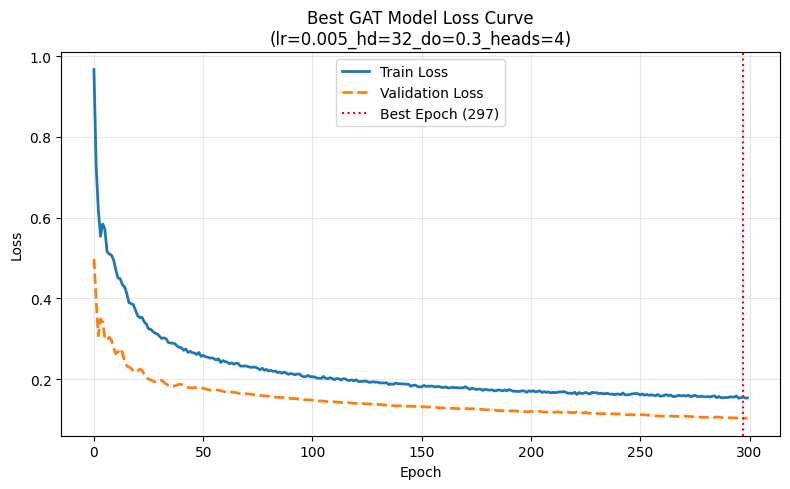

In [80]:
# ==================== 绘制GAT Loss曲线 ====================
plt.figure(figsize=(8, 5))
best_gat_train_losses = best_gat_result['train_losses']
best_gat_val_losses = best_gat_result['val_losses']
plt.plot(best_gat_train_losses, label='Train Loss', linewidth=2)
plt.plot(best_gat_val_losses, label='Validation Loss', linewidth=2, linestyle='--')
plt.axvline(x=best_gat_result['best_epoch'], color='r', linestyle=':',
            label=f'Best Epoch ({best_gat_result["best_epoch"]})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best GAT Model Loss Curve\n({best_gat_config})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [81]:
# ==================== 使用最佳GAT模型在测试集上评估 ====================
# 获取最佳模型
best_gat_model = best_gat_result['model']

# 在测试集上评估
gat_test_metrics, gat_test_cm, gat_y_true_test, gat_y_pred_test = evaluate_model(
    best_gat_model, data, data.test_mask, class_names=['Illicit', 'Licit']
)

# 打印测试集评估结果
print("=" * 60)
print("GAT测试集评估结果:")
print("=" * 60)
print(f"模型配置: {best_gat_config}")
print(f"准确率 (Accuracy):  {gat_test_metrics['accuracy']:.4f}")
print(f"精准度 (Precision): {gat_test_metrics['precision']:.4f}")
print(f"召回率 (Recall):    {gat_test_metrics['recall']:.4f}")
print(f"F1分数 (F1-Score):  {gat_test_metrics['f1_score']:.4f}")
print("=" * 60)

# 打印分类报告
print("\nGAT分类报告:")
print(classification_report(gat_y_true_test, gat_y_pred_test,
                            target_names=['Illicit', 'Licit'],
                            digits=4))


GAT测试集评估结果:
模型配置: lr=0.005_hd=32_do=0.3_heads=4
准确率 (Accuracy):  0.9693
精准度 (Precision): 0.9683
召回率 (Recall):    0.9693
F1分数 (F1-Score):  0.9683

GAT分类报告:
              precision    recall  f1-score   support

     Illicit     0.8967    0.7773    0.8327       458
       Licit     0.9761    0.9902    0.9831      4199

    accuracy                         0.9693      4657
   macro avg     0.9364    0.8838    0.9079      4657
weighted avg     0.9683    0.9693    0.9683      4657



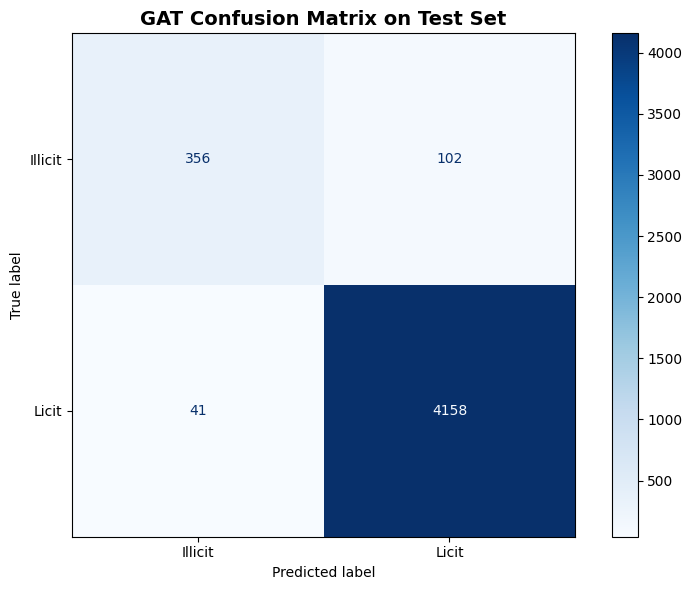

In [82]:
# ==================== 绘制GAT测试集混淆矩阵 ====================
# 只显示测试集的混淆矩阵
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=gat_test_cm,
                              display_labels=['Illicit', 'Licit'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('GAT Confusion Matrix on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# GIN (Graph Isomorphism Networks) 模型


In [83]:
# ==================== GIN模型定义 ====================
import torch.nn as nn
from torch_geometric.nn import GINConv

class GIN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes, num_layers=2, dropout=0.5):
        super(GIN, self).__init__()
        # 第一层GIN：使用MLP进行特征变换
        nn1 = nn.Sequential(
            nn.Linear(num_features, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        self.conv1 = GINConv(nn1, train_eps=True)
        
        # 第二层GIN：输出层
        nn2 = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_classes)
        )
        self.conv2 = GINConv(nn2, train_eps=True)
        
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # 第一层GIN + ReLU + Dropout
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # 第二层GIN
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [89]:
# ==================== GIN网格搜索：学习率 + 模型结构 ====================
# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# 网格搜索的超参数范围
learning_rates = [0.001, 0.005, 0.01]  # 学习率
hidden_dims = [16,32]  # 隐藏层维度
dropouts = [0.3]  # Dropout率

# 模型参数
num_features = data.x.shape[1]  # 166
num_classes = 2  # illicit(0) 和 licit(1)

# 存储所有超参数组合的结果
gin_results = {}
total_combinations = len(learning_rates) * len(hidden_dims) * len(dropouts)
current_combination = 0

print("开始GIN网格搜索（学习率 + 模型结构）...")
print(f"总组合数: {total_combinations}")
print("=" * 60)

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        for dropout in dropouts:
            current_combination += 1
            config_key = f"lr={lr}_hd={hidden_dim}_do={dropout}"

            print(f"\n[{current_combination}/{total_combinations}] 配置: {config_key}")
            print("-" * 60)

            # 创建模型
            model = GIN(num_features, hidden_dim, num_classes, dropout=dropout).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
            criterion = nn.NLLLoss()

            # 训练（带早停）
            train_losses, val_losses, best_epoch = train_with_early_stopping(
                model, data, optimizer, criterion,
                max_epochs=400, patience=20, min_delta=0.001
            )

            # 在验证集上评估
            val_metrics, _, _, _ = evaluate_model(model, data, data.val_mask)

            # 保存结果
            gin_results[config_key] = {
                'lr': lr,
                'hidden_dim': hidden_dim,
                'dropout': dropout,
                'train_losses': train_losses,
                'val_losses': val_losses,
                'best_epoch': best_epoch,
                'val_metrics': val_metrics,
                'model': model
            }

            print(f"验证集 - 准确率: {val_metrics['accuracy']:.4f}, "
                  f"精准度: {val_metrics['precision']:.4f}, "
                  f"召回率: {val_metrics['recall']:.4f}, "
                  f"F1: {val_metrics['f1_score']:.4f}")

# 选择最佳配置（基于验证集F1分数）
best_gin_config = max(gin_results.keys(), key=lambda k: gin_results[k]['val_metrics']['f1_score'])
best_gin_result = gin_results[best_gin_config]

print("\n" + "=" * 60)
print("GIN最佳配置:")
print(f"  学习率: {best_gin_result['lr']}")
print(f"  隐藏层维度: {best_gin_result['hidden_dim']}")
print(f"  Dropout: {best_gin_result['dropout']}")
print(f"  验证集F1分数: {best_gin_result['val_metrics']['f1_score']:.4f}")
print("=" * 60)


Using device: cuda
开始GIN网格搜索（学习率 + 模型结构）...
总组合数: 6

[1/6] 配置: lr=0.001_hd=16_do=0.3
------------------------------------------------------------
Epoch 010, Train Loss: 0.4999, Val Loss: 0.4932, Best Epoch: 10
Epoch 020, Train Loss: 0.3909, Val Loss: 0.3962, Best Epoch: 20
Epoch 030, Train Loss: 0.3384, Val Loss: 0.3551, Best Epoch: 30
Epoch 040, Train Loss: 0.3122, Val Loss: 0.3338, Best Epoch: 40
Epoch 050, Train Loss: 0.2928, Val Loss: 0.3110, Best Epoch: 50
Epoch 060, Train Loss: 0.2779, Val Loss: 0.2973, Best Epoch: 60
Epoch 070, Train Loss: 0.2682, Val Loss: 0.2884, Best Epoch: 69
Epoch 080, Train Loss: 0.2591, Val Loss: 0.2805, Best Epoch: 79
Epoch 090, Train Loss: 0.2515, Val Loss: 0.2724, Best Epoch: 89
Epoch 100, Train Loss: 0.2453, Val Loss: 0.2646, Best Epoch: 99
Epoch 110, Train Loss: 0.2371, Val Loss: 0.2563, Best Epoch: 109
Epoch 120, Train Loss: 0.2311, Val Loss: 0.2486, Best Epoch: 119
Epoch 130, Train Loss: 0.2238, Val Loss: 0.2404, Best Epoch: 129
Epoch 140, Train Lo

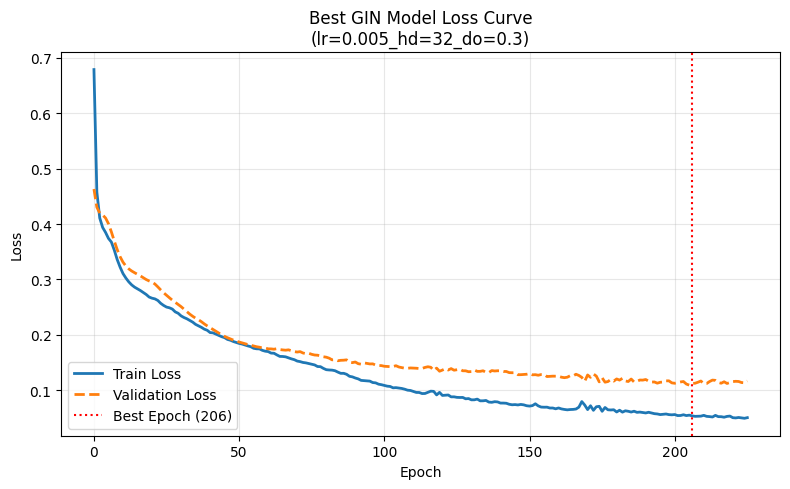

In [90]:
# ==================== 绘制GIN Loss曲线 ====================
plt.figure(figsize=(8, 5))
best_gin_train_losses = best_gin_result['train_losses']
best_gin_val_losses = best_gin_result['val_losses']
plt.plot(best_gin_train_losses, label='Train Loss', linewidth=2)
plt.plot(best_gin_val_losses, label='Validation Loss', linewidth=2, linestyle='--')
plt.axvline(x=best_gin_result['best_epoch'], color='r', linestyle=':',
            label=f'Best Epoch ({best_gin_result["best_epoch"]})')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Best GIN Model Loss Curve\n({best_gin_config})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [91]:
# ==================== 使用最佳GIN模型在测试集上评估 ====================
# 获取最佳模型
best_gin_model = best_gin_result['model']

# 在测试集上评估
gin_test_metrics, gin_test_cm, gin_y_true_test, gin_y_pred_test = evaluate_model(
    best_gin_model, data, data.test_mask, class_names=['Illicit', 'Licit']
)

# 打印测试集评估结果
print("=" * 60)
print("GIN测试集评估结果:")
print("=" * 60)
print(f"模型配置: {best_gin_config}")
print(f"准确率 (Accuracy):  {gin_test_metrics['accuracy']:.4f}")
print(f"精准度 (Precision): {gin_test_metrics['precision']:.4f}")
print(f"召回率 (Recall):    {gin_test_metrics['recall']:.4f}")
print(f"F1分数 (F1-Score):  {gin_test_metrics['f1_score']:.4f}")
print("=" * 60)

# 打印分类报告
print("\nGIN分类报告:")
print(classification_report(gin_y_true_test, gin_y_pred_test,
                            target_names=['Illicit', 'Licit'],
                            digits=4))


GIN测试集评估结果:
模型配置: lr=0.005_hd=32_do=0.3
准确率 (Accuracy):  0.9671
精准度 (Precision): 0.9664
召回率 (Recall):    0.9671
F1分数 (F1-Score):  0.9667

GIN分类报告:
              precision    recall  f1-score   support

     Illicit     0.8538    0.8035    0.8279       458
       Licit     0.9787    0.9850    0.9818      4199

    accuracy                         0.9671      4657
   macro avg     0.9163    0.8942    0.9049      4657
weighted avg     0.9664    0.9671    0.9667      4657



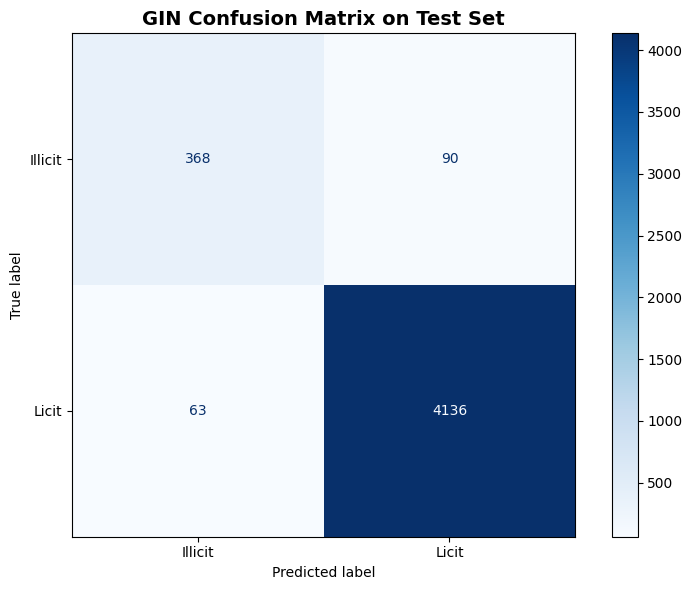

In [92]:
# ==================== 绘制GIN测试集混淆矩阵 ====================
# 只显示测试集的混淆矩阵
fig, ax = plt.subplots(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=gin_test_cm,
                              display_labels=['Illicit', 'Licit'])
disp.plot(ax=ax, cmap='Blues', values_format='d')
ax.set_title('GIN Confusion Matrix on Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


# 三个模型准确率对比（训练200轮）


In [94]:
# ==================== 训练函数（记录准确率） ====================
def train_with_accuracy(model, data, optimizer, criterion, max_epochs=200):
    """
    训练函数，记录每个epoch的训练集和验证集准确率
    Args:
        model: 模型
        data: 图数据
        optimizer: 优化器
        criterion: 损失函数
        max_epochs: 最大训练轮次
    Returns:
        train_accuracies: 训练集准确率列表
        val_accuracies: 验证集准确率列表
    """
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(1, max_epochs + 1):
        # 训练阶段
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        
        # 计算训练集准确率
        pred = out.argmax(dim=1)
        train_acc = (pred[data.train_mask] == data.y[data.train_mask]).sum().item() / data.train_mask.sum().item()
        train_accuracies.append(train_acc)
        
        # 验证阶段
        model.eval()
        with torch.no_grad():
            out = model(data)
            # 计算验证集准确率
            pred = out.argmax(dim=1)
            val_acc = (pred[data.val_mask] == data.y[data.val_mask]).sum().item() / data.val_mask.sum().item()
            val_accuracies.append(val_acc)
        
        # 打印进度
        if epoch % 20 == 0:
            print(f'Epoch {epoch:03d}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')
    
    return train_accuracies, val_accuracies


In [95]:
# ==================== 训练三个模型并记录准确率 ====================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

num_features = data.x.shape[1]  # 166
num_classes = 2  # illicit(0) 和 licit(1)

# 存储结果
results_accuracy = {}

# 1. 训练GCN模型
print("\n" + "=" * 60)
print("训练GCN模型 (lr=0.01, hidden_dim=64, dropout=0.3)")
print("=" * 60)
gcn_model = GCN(num_features, hidden_dim=64, num_classes=num_classes, dropout=0.3).to(device)
gcn_optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01, weight_decay=5e-4)
gcn_criterion = nn.NLLLoss()

gcn_train_acc, gcn_val_acc = train_with_accuracy(gcn_model, data, gcn_optimizer, gcn_criterion, max_epochs=200)
results_accuracy['GCN'] = {
    'train_acc': gcn_train_acc,
    'val_acc': gcn_val_acc
}

# 2. 训练GAT模型
print("\n" + "=" * 60)
print("训练GAT模型 (lr=0.005, hidden_dim=32, dropout=0.3, heads=4)")
print("=" * 60)
gat_model = GAT(num_features, hidden_dim=32, num_classes=num_classes, heads=4, dropout=0.3).to(device)
gat_optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005, weight_decay=5e-4)
gat_criterion = nn.NLLLoss()

gat_train_acc, gat_val_acc = train_with_accuracy(gat_model, data, gat_optimizer, gat_criterion, max_epochs=200)
results_accuracy['GAT'] = {
    'train_acc': gat_train_acc,
    'val_acc': gat_val_acc
}

# 3. 训练GIN模型
print("\n" + "=" * 60)
print("训练GIN模型 (lr=0.005, hidden_dim=32, dropout=0.3)")
print("=" * 60)
gin_model = GIN(num_features, hidden_dim=32, num_classes=num_classes, dropout=0.3).to(device)
gin_optimizer = torch.optim.Adam(gin_model.parameters(), lr=0.005, weight_decay=5e-4)
gin_criterion = nn.NLLLoss()

gin_train_acc, gin_val_acc = train_with_accuracy(gin_model, data, gin_optimizer, gin_criterion, max_epochs=200)
results_accuracy['GIN'] = {
    'train_acc': gin_train_acc,
    'val_acc': gin_val_acc
}

print("\n训练完成！")


Using device: cuda

训练GCN模型 (lr=0.01, hidden_dim=64, dropout=0.3)
Epoch 020, Train Acc: 0.8784, Val Acc: 0.8787
Epoch 040, Train Acc: 0.9125, Val Acc: 0.9156
Epoch 060, Train Acc: 0.9234, Val Acc: 0.9289
Epoch 080, Train Acc: 0.9301, Val Acc: 0.9336
Epoch 100, Train Acc: 0.9356, Val Acc: 0.9396
Epoch 120, Train Acc: 0.9408, Val Acc: 0.9444
Epoch 140, Train Acc: 0.9426, Val Acc: 0.9476
Epoch 160, Train Acc: 0.9451, Val Acc: 0.9495
Epoch 180, Train Acc: 0.9466, Val Acc: 0.9515
Epoch 200, Train Acc: 0.9477, Val Acc: 0.9510

训练GAT模型 (lr=0.005, hidden_dim=32, dropout=0.3, heads=4)
Epoch 020, Train Acc: 0.8676, Val Acc: 0.8890
Epoch 040, Train Acc: 0.8940, Val Acc: 0.9296
Epoch 060, Train Acc: 0.9109, Val Acc: 0.9373
Epoch 080, Train Acc: 0.9182, Val Acc: 0.9412
Epoch 100, Train Acc: 0.9274, Val Acc: 0.9461
Epoch 120, Train Acc: 0.9290, Val Acc: 0.9519
Epoch 140, Train Acc: 0.9328, Val Acc: 0.9553
Epoch 160, Train Acc: 0.9336, Val Acc: 0.9570
Epoch 180, Train Acc: 0.9379, Val Acc: 0.9601
Epo

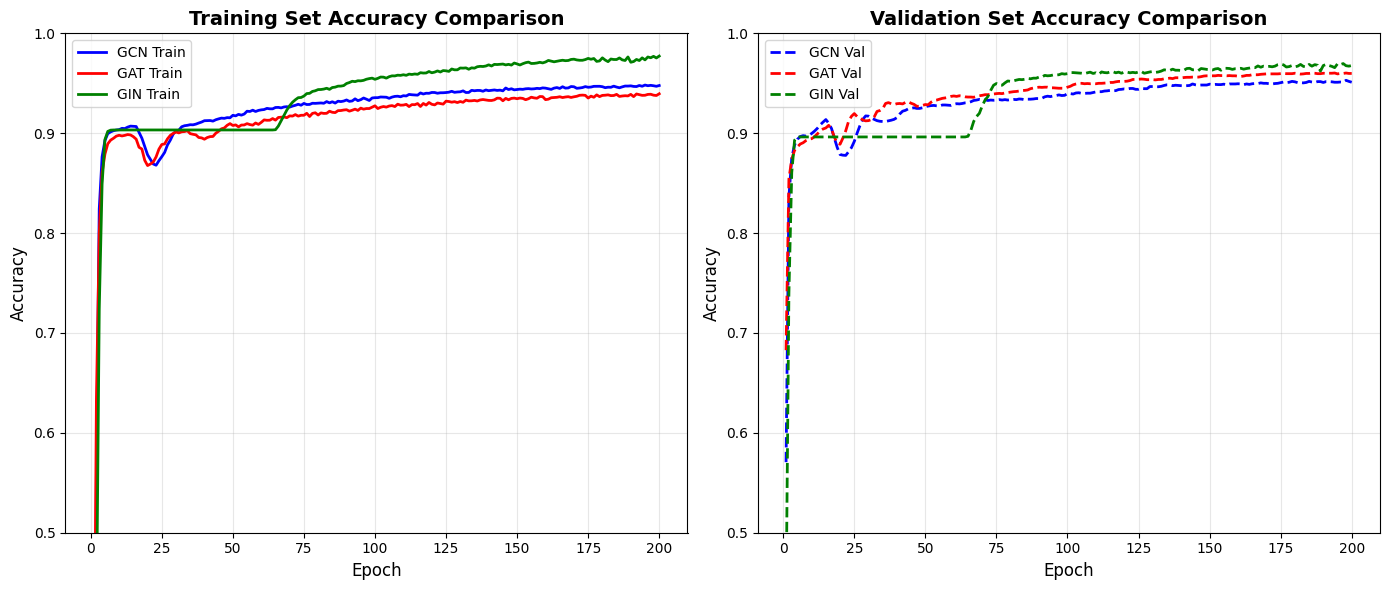

In [98]:
# ==================== 绘制三个模型的准确率对比图 ====================
plt.figure(figsize=(14, 6))

# 创建epoch列表
epochs = list(range(1, 201))

# 绘制训练集准确率
plt.subplot(1, 2, 1)
plt.plot(epochs, results_accuracy['GCN']['train_acc'], label='GCN Train', linewidth=2, color='blue')
plt.plot(epochs, results_accuracy['GAT']['train_acc'], label='GAT Train', linewidth=2, color='red')
plt.plot(epochs, results_accuracy['GIN']['train_acc'], label='GIN Train', linewidth=2, color='green')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Training Set Accuracy Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

# 绘制验证集准确率
plt.subplot(1, 2, 2)
plt.plot(epochs, results_accuracy['GCN']['val_acc'], label='GCN Val', linewidth=2, color='blue', linestyle='--')
plt.plot(epochs, results_accuracy['GAT']['val_acc'], label='GAT Val', linewidth=2, color='red', linestyle='--')
plt.plot(epochs, results_accuracy['GIN']['val_acc'], label='GIN Val', linewidth=2, color='green', linestyle='--')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Validation Set Accuracy Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.ylim([0.5, 1.0])

plt.tight_layout()
plt.show()


GIN 的总体表现似乎最好，尤其是在后期稳定之后。它的精度最高，但初期表现出不稳定性。

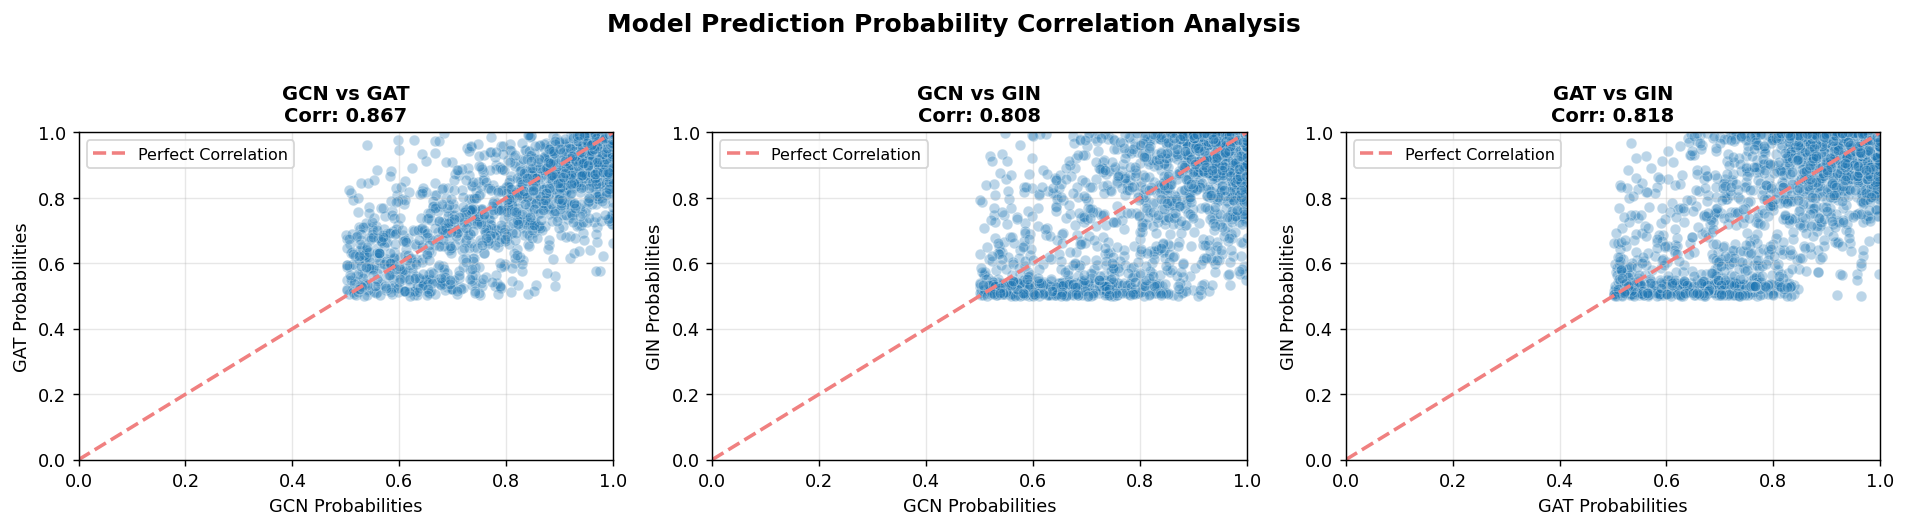


模型间预测概率相关系数矩阵:
          GCN       GAT       GIN
GCN  1.000000  0.866743  0.807960
GAT  0.866743  1.000000  0.818264
GIN  0.807960  0.818264  1.000000


In [102]:
# ==================== 绘制模型间预测概率相关性散点图 ====================
combinations = [('GCN', 'GAT'), ('GCN', 'GIN'), ('GAT', 'GIN')]

fig, axes = plt.subplots(1, 3, figsize=(15, 4), dpi=128)

for ax, (model1, model2) in zip(axes, combinations):
    # 准备散点图数据
    scatter_data = pd.DataFrame({
        f'{model1}_Probabilities': scatter_df[model1].values,
        f'{model2}_Probabilities': scatter_df[model2].values
    })
    
    # 绘制散点图
    sns.scatterplot(
        data=scatter_data,
        x=f'{model1}_Probabilities',
        y=f'{model2}_Probabilities',
        color='C0',
        edgecolor='white',
        marker='o',
        alpha=0.3,
        ax=ax
    )
    
    # 计算相关系数
    corr_value = np.corrcoef(
        scatter_df[model1].values,
        scatter_df[model2].values
    )[0, 1]
    
    # 绘制完美相关性的对角线
    ax.plot([0, 1], [0, 1], ls='--', color='lightcoral', 
            label=f'Perfect Correlation', alpha=1.0, linewidth=2)
    
    # 设置标题和标签
    ax.set_title(f'{model1} vs {model2}\nCorr: {corr_value:.3f}', 
                 fontsize=11, fontweight='bold')
    ax.set_xlabel(f'{model1} Probabilities', fontsize=10)
    ax.set_ylabel(f'{model2} Probabilities', fontsize=10)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.legend(loc='upper left', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Model Prediction Probability Correlation Analysis', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# 打印相关系数矩阵
print("\n" + "=" * 60)
print("模型间预测概率相关系数矩阵:")
print("=" * 60)
corr_matrix = scatter_df.corr()
print(corr_matrix)
print("=" * 60)
